# **House_Predictions using Boston_Housing Dataset with Regression Model** 

---

### **Regression uses targets (Continuous Values) instead of labels (Discrete Values)**

## ** Loading Dataset **

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 1us/step


## **Checking Shape of Data**

In [2]:
train_data.shape   # samples, features ; 2D tensor
                      # 404 training samples, with 13 features e.g. Crime Rate 

(404, 13)

In [3]:
test_data.shape

(102, 13)

## **Checking train_targets**

In [4]:
train_targets  # the median values of owner-occupied homes (in USD, according to 1970s period)

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

# Preparing Data

---

## Normalizing the Data

### feature-wise normalization i.e. (feature - mean)/ standard deviation using Numpy
### Using Normalization, to prevent hetrogenous ranges feeding to a Neural Network or to feed homogenous range (each feature close to zero) to a NN.

In [0]:
mean = train_data.mean(axis = 0)   # features on axis 0
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std

# Note: the quantities use for normalizing the test data, have been computed on train data (BEWARE: Never use computing on test data)

test_data -= mean
test_data /= std

# Building Network 

---

## Defining the Model 

### Example of Scalar Regression, i.e. in which a single continuous value will be predicted.

### No ACTIVATION function will be used on OUTPUT layer, because we are willing to predict a single unit, i.e. the last layer will be a linear layer, allowing the network to predict values in  any range. 

### Sigmoid is not used on last layer, because it will restrict the range (an output can take) between 0 to 1.

### MSE (Mean Squaared Error, squared difference of predictions and targets) is used as a loss function, because of the industry practices.

### MEA (Mean Absolute Error, the absolute difference value of predictions and targets i.e. a MAE of 0.5 will reflect that predictions are off by USD 500 from targets on average)



In [0]:
from keras import models
from keras import layers

# For Reusability, model is defined as a function.

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],))) # number of features (13) are used as vector in input shape
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dense(1)) # no activation function
  model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
  return model

# Validation Step : Using K-fold Cross-Validation Method

---

### Especially, when you have small dataset or else it will take more time to process
### In order to aviod increasing the variance between validation and training set split i.e. to allow more room for generalization

---

### Steps:
### 1) Split the available pre-split train_data into K-partitions (typically K=4 or 5)
### 2) Then instantiate  K identical models
### 3) Training each one on K - 1 partitions while evaluating on the rest of the partitions.
### 4) Final Validation Score will be the average of the K Validation Scores obtained.



In [0]:
import numpy as np

In [8]:
k = 4
num_val_samples = len(train_data) // 4
num_epochs = 100
all_scores = []

for i in range(k):
  print('processing fold # ', i)
  # prepare the validation data: data from partition # k
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  
  # prepare the training data: data from data - k
  partial_train_data = np.concatenate(                    
      [train_data[:i * num_val_samples],
      train_data[(i + 1 ) * num_val_samples:]],
  axis = 0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
      train_targets[(i + 1 ) * num_val_samples:]],
  axis = 0)
  # Build the Keras Models (already commpiled)
  model = build_model()
  # Train the model (in silence mode, verbose = 0)
  model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1, verbose = 0)
  # Evaluate the model on the validation data
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
  all_scores.append(val_mae)
       

processing fold #  0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing fold #  1
processing fold #  2
processing fold #  3


## All Scores

In [9]:
all_scores 

[2.0581326413862775, 2.2001309324019025, 2.8750618802438868, 2.410775157484678]

## Final Validation Score

In [10]:
np.mean(all_scores)  # we are still off by USD 2367 on average

2.386025152879186

## Updating the Epochs

In [11]:
k = 4
num_val_samples = len(train_data) // 4
num_epochs = 500
all_mae_histories = []

for i in range(k):
  print('processing fold # ', i)
  # prepare the validation data: data from partition # k
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  
  # prepare the training data: data from data - k
  partial_train_data = np.concatenate(                    
      [train_data[:i * num_val_samples],
      train_data[(i + 1 ) * num_val_samples:]],
  axis = 0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
      train_targets[(i + 1 ) * num_val_samples:]],
  axis = 0)
  # Build the Keras Models (already commpiled)
  model = build_model()
  # Train the model (in silence mode, verbose = 0)
  history = model.fit(partial_train_data, partial_train_targets, validation_data = (val_data, val_targets), epochs = num_epochs, batch_size = 1, verbose = 0)
  mae_history = history.history['val_mean_absolute_error']
  all_mae_histories.append(mae_history)
       

processing fold #  0
processing fold #  1
processing fold #  2
processing fold #  3


In [0]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# Plotting Validation Scores

In [0]:
import matplotlib.pyplot as plt

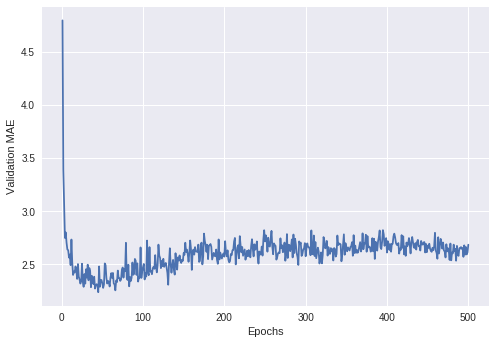

In [14]:
plt.plot(range(1, len(average_mae_history) + 1 ), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Plotting Validation Scores - Excluding the first 10 data points

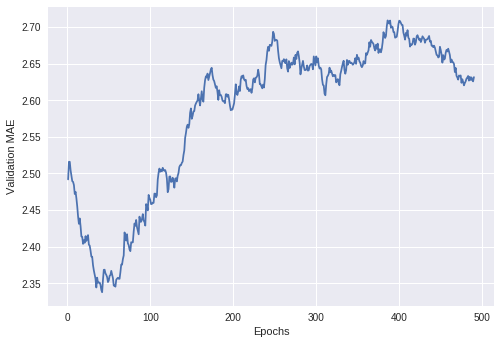

In [15]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1- factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
      

# Training the final model

In [16]:
# Get a fresh compiled model.
model = build_model()

#Training on Entire Data
model.fit(train_data, train_targets, epochs = 80, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


# Final Result

In [17]:
test_mse_score   

17.978136548808976